## BoilerPlate command

It’s standard practice to start the notebook with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.



In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Importing Fast AI library

Let’s import fastai library and define our batch_size parameter to 64. Usually, image databases are enormous, so we need to feed these images into a GPU using batches, batch size 16428 means that we will feed 64 images at once to update parameters of our deep learning model. If you are running out of memory because of smaller GPU RAM, you can reduce batch size to 32 or 16.

In [2]:
from fastai.vision import *
from lenet import *
bs=64

## Downloading Dataset

TO download MNIST data use following command

path = untar_data(URLs.MNIST);
path

By running the above command, the data is downloaded and stored in the path shown above. Let's look at how the data directory is set up as we have to import data from these directories. Let's start by looking at path directory, and we can see below that our data already have training and testing folder.

In [3]:
path = Path('../data/mnist_png/')

Let's look inside the training folder. Data is split by digits 1 to 9 in a different folder.

In [4]:
path.ls()

[WindowsPath('../data/mnist_png/models'),
 WindowsPath('../data/mnist_png/testing'),
 WindowsPath('../data/mnist_png/training')]

In [5]:
(path/'training').ls()

[WindowsPath('../data/mnist_png/training/0'),
 WindowsPath('../data/mnist_png/training/1'),
 WindowsPath('../data/mnist_png/training/2'),
 WindowsPath('../data/mnist_png/training/3'),
 WindowsPath('../data/mnist_png/training/4'),
 WindowsPath('../data/mnist_png/training/5'),
 WindowsPath('../data/mnist_png/training/6'),
 WindowsPath('../data/mnist_png/training/7'),
 WindowsPath('../data/mnist_png/training/8'),
 WindowsPath('../data/mnist_png/training/9')]

Within each digit folder, we have images.

In [6]:
(path/'training/0').ls()[1:5]

[WindowsPath('../data/mnist_png/training/0/1000.png'),
 WindowsPath('../data/mnist_png/training/0/10005.png'),
 WindowsPath('../data/mnist_png/training/0/10010.png'),
 WindowsPath('../data/mnist_png/training/0/10022.png')]

## Importing Data

In [7]:
ds_tfms = get_transforms(do_flip=False, flip_vert=False, max_rotate= 15,max_zoom=1.1, max_lighting=0.2, max_warp=0.2)

data = (ImageItemList.from_folder(path, convert_mode='L')
        .split_by_folder(train='training', valid='testing')
        .label_from_folder()
        .transform(tfms=ds_tfms, size=28)
        .databunch(bs=bs))

In [8]:
data.train_ds

LabelList
y: CategoryList (60000 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: ..\data\mnist_png
x: ImageItemList (60000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: ..\data\mnist_png

In [9]:
data.valid_ds

LabelList
y: CategoryList (10000 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: ..\data\mnist_png
x: ImageItemList (10000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: ..\data\mnist_png

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
10


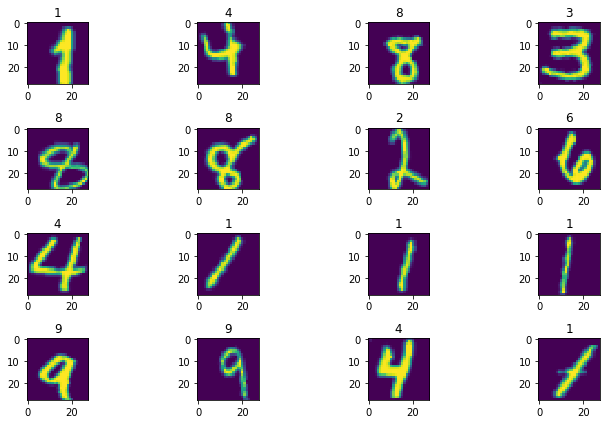

In [10]:
print(data.classes) ## Prints class labels
print(data.c) ## Prints number of classes
data.show_batch(rows=4, figsize=(10,6), hide_axis=False) ## Show sample data

## About the model

LeNet architecture was first introduced by first introduced by LeCun et al. in their 1998 paper, Gradient-Based Learning Applied to Document Recognition. LeNet is quite a simple architecture as represented in image below.
<img src="https://blog.dataiku.com/hs-fs/hubfs/Dataiku%20Dec%202016/Image/le_net.png?width=620&name=le_net.png">

The architecture can represented by following notation - 

(CONV=>RELU=>POOL)*2 => (FC=>RELU) => FC=>SOFTMAX

## Training the model

We have defined our shallownet model in lenet.py file, now we need to train it. We can use FastAI's *Learner* function which makes it easier to leverage modern enhancement in optimization methods and many other neat tricks like  1-Cycle style training as highlighted in [Leslie Smith's paper](https://arxiv.org/pdf/1803.09820.pdf) for faster convergence. Let's define our Learner class -

In [27]:
## Defining the learner
lenet_learner = Learner(data=data, 
                      model=LeNet(n_class=data.c, 
                                       size=28, 
                                       in_channels=1), 
                      loss_func=nn.CrossEntropyLoss(),
                      metrics=accuracy)

In [28]:
lenet_learner.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 20, 28, 28]     520        True      
______________________________________________________________________
Conv2d               [64, 50, 14, 14]     25050      True      
______________________________________________________________________
Linear               [64, 500]            1225500    True      
______________________________________________________________________
Linear               [64, 10]             5010       True      
______________________________________________________________________

Total params:  1256080
Total trainable params:  1256080
Total non-trainable params:  0


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


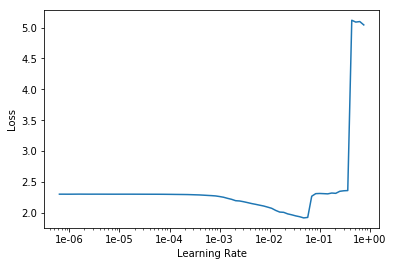

In [29]:
## Finidng Ideal learning late
lenet_learner.lr_find()
lenet_learner.recorder.plot()

In [30]:
lenet_learner.fit_one_cycle(5,1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.147864,0.089359,0.971400
2,0.117830,0.075181,0.978500
3,0.093218,0.040102,0.988000
4,0.050197,0.023681,0.992000
5,0.041383,0.022327,0.993400


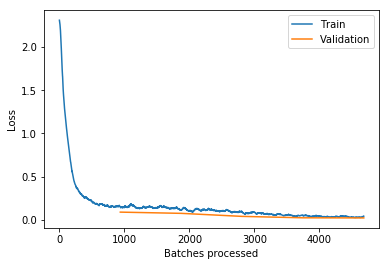

In [32]:
lenet_learner.recorder.plot_losses()

In [33]:
from sklearn.metrics import classification_report
interp = ClassificationInterpretation.from_learner(lenet_learner)
print(classification_report(interp.y_true,interp.pred_class))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       0.99      1.00      0.99       974
           9       0.99      0.98      0.99      1009

   micro avg       0.99      0.99      0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



As we can see we are reached 99.3% accuracy just by running LeNet for 5 epochs. Convolutional neural networks are really ground breaking.

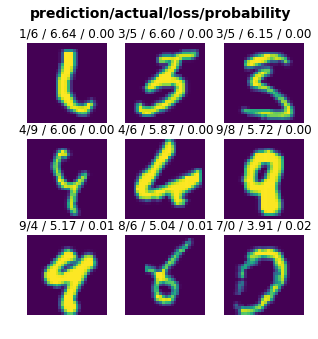

In [37]:
## Plotting Top losses
interp.plot_top_losses(9,figsize=(5,5))

As we can see that all of these cases are really difficult even by human inference.